# Superconducting Qubit Refrigerator: Produce Pareto Front
Analyze the performance of cycles previously identified using ```0_train.ipynb```. See that Jupyter Notebook for more details on this system.

This Jupyter Notebook allows to export a text file with all the data to produce a Pareto front by evaluating the deterministic policies. It allows to view the training curves and to evaluate the performance of individual or collections of trainings (outputting the average reward, power, entropy production, efficiency, and coherence). 
#### Import modules

In [2]:
import sys
import os
sys.path.append(os.path.join('..','src'))
import numpy as np
import plotting
import extra
import sac_multi

## Produce Pareto-front txt file from the deterministic Policy
Produces a txt file with all the data to plot the Pareto front by evaluating the _deterministic_ policies learned during training. It does this by evaluating the performance of all trainings contained in the folder ```main_dir```, such that the parameters in ```parameters.txt``` satisfy the conditions in ```conditions_dict``` (see next cell for an example). If ```conditions_dict``` is left empty, all folders are evaluated. The Pareto front data is exported to ```main_dir``` as ```det_pareto.txt```. The evaluation of the _deterministic_ policy is performed doing ```24000``` steps on the environment and exponentially averaging the reward, the power, and the negative entropy production with ```gamma=0.99993```.

In [ ]:
main_dir = "../paper_plot_data/qubit_refrigerator/pareto"
conditions_dict = {} 

#used to evaluate the efficiency
def eff(pow,entropy,bh,bc):
    return pow*bh/( pow*(bc-bh) + np.abs(entropy) )

det_data_list = []
log_dirs = extra.log_dirs_given_criteria(main_dir, conditions_dict)
for (i, log_dir) in enumerate(log_dirs): 
    print(f"Evaluating i = {i+1} of {len(log_dirs)}")
    
    #load the data
    loaded_train = sac_multi.SacTrain()
    loaded_train.load_train(log_dir, no_train=True)
    
    #evaluate the model
    det_eval = loaded_train.evaluate_current_policy(deterministic=True, steps=24000, gamma=0.99993,actions_to_plot=120,
                    save_policy_to_file_name="det_policy.txt",actions_ylim=None, suppress_show=False,dont_clear_output=False)
    
    #append data
    model_parameters = extra.params_from_log_dir(log_dir)
    (a_val, bh, bc) = (model_parameters["A_END"],float(model_parameters["b0"]),float(model_parameters["b1"]))
    det_data_list.append([det_eval[1],det_eval[2], eff(det_eval[1],det_eval[2],bh,bc), a_val, det_eval[0]])

#save the Pareto front txt file
np.savetxt(os.path.join(main_dir,"det_pareto.txt"), np.array(det_data_list, dtype=np.float32))


## View and evaluate all cycles with given parameters
The following code looks into the ```main_dir``` folder, and chooses all training folders where the ```params.txt``` has the parameters specificed in ```conditions_dict```, that can consist of multiple conditions. If it's an empty dictionary, all folders are considered. 
For each of these folder:
- it prints the folder location, the last 6 running rewards that were logged, and the average of these 6 values;
- it evaluates the performance of the _deterministic_ policy performing ```steps=24000``` steps on the environment exponentially averaging the reward, the power, and the negative entropy production with ```gamma=0.99993```. These 3 averages are plotted as a function of step to prove their convergence, and also the last ```100``` actions are plotted;
- it prints the average reward, power, negative entropy, and efficiency computed with the deterministic policy as described above;
- it prints the average coherence generated during the deterministic cycles as described above.


i: 0, log_dir: ../paper_plot_data/exta_runs/qubit_refrigerator/3/2022_03_01-10_08_57_aend=0.4
Last rewards: [0.16438554 0.17145846 0.19590414 0.17638197 0.19846519 0.16768764]
Avg reward: 0.17904715477828934


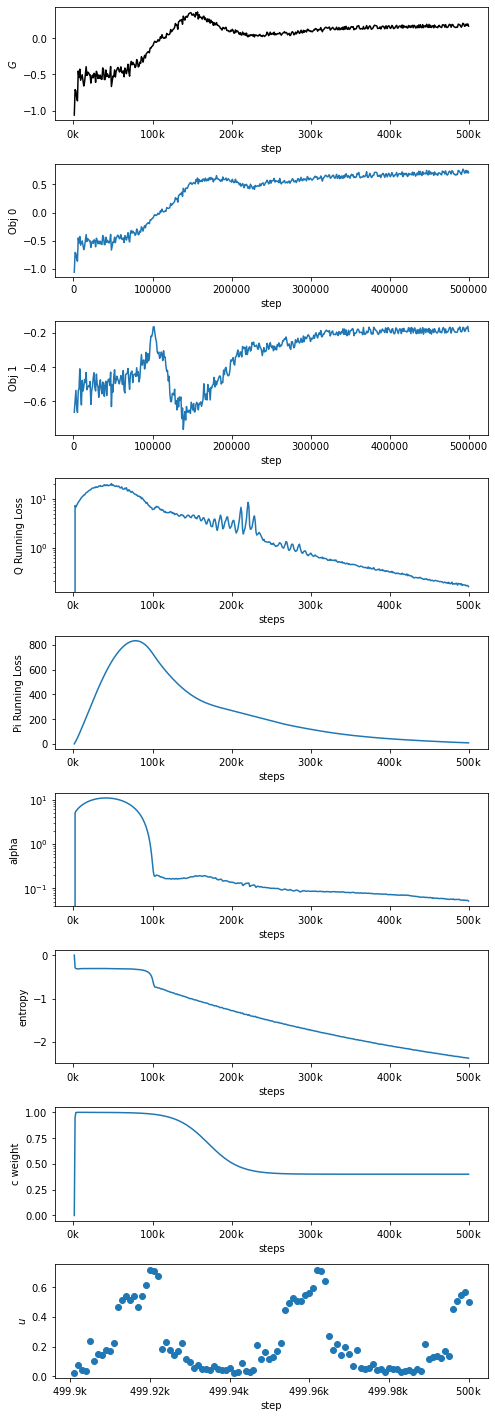


Number of parameters: 	 pi: 174146, 	 qa1: 239681, 	 qa2: 239681, 	 qb1: 239681, 	 qb2: 239681,



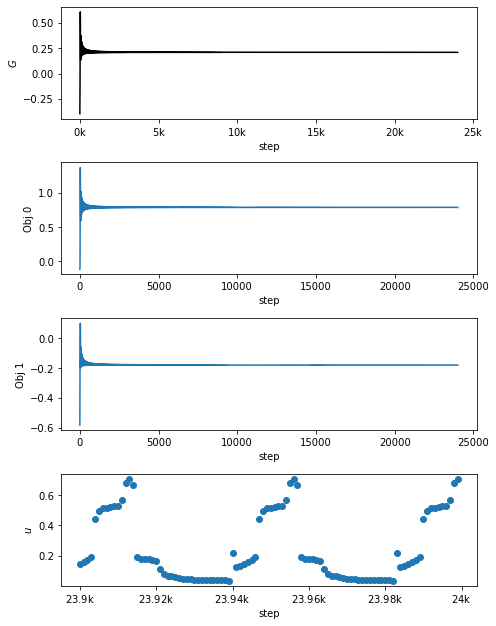

Det. Reward: 0.20823298362212025
Det. Power, Entropy, Efficiency: 0.7894413872210797, 0.17923928629604008,0.936229902943174
Coherence: 0.03554488182729926



In [7]:
main_dir = "../paper_plot_data/exta_runs/qubit_refrigerator/3"
conditions_dict = {"A_END": "0.4"}

#parameters to compute the efficiency from power and entropy production
tc = 0.15
th = 0.3

#faster but less accurate evaluation using gamma=0.9999, steps=9000
gamma = 0.99993
steps = 24000

log_dirs = extra.log_dirs_given_criteria(main_dir, conditions_dict)
for (i, log_dir) in enumerate(log_dirs):
    #print directory and index
    print(f"i: {i}, log_dir: {log_dir}")
    
    #print last running rewards and their average
    last_rewards, avg_reward = extra.ret_last_rewards_and_avg(log_dir,number_of_rewards=6)
    print(f"Last rewards: {last_rewards}")
    print(f"Avg reward: {avg_reward}")
    
    #show the training plots
    plotting.plot_sac_logs(log_dir,is_tri=False,plot_to_file_line=None,actions_per_log=1000,
      suppress_show=False,save_plot=False,actions_ylim=None,actions_to_plot=100,dont_clear_output=True)
    
    #evaluate the deterministic policy 
    loaded_train = sac_multi.SacTrain()
    loaded_train.load_train(log_dir, no_train=True)
    eval_reward_det = loaded_train.evaluate_current_policy(deterministic=True, steps=steps, gamma=gamma,actions_to_plot=100,
                        actions_ylim=None, suppress_show=False,dont_clear_output=True)
    print(f"Det. Reward: {eval_reward_det[0]}")
    print(f"Det. Power, Entropy, Efficiency: {eval_reward_det[1]}, {-eval_reward_det[2]}," + 
              f"{eval_reward_det[1]*tc/(eval_reward_det[1]*(th-tc) -eval_reward_det[2]*th*tc ) }")
    
    #print the coherence if returned by the environment
    if len(eval_reward_det)>3:
        print(f"Coherence: { eval_reward_det[3]}")
    
    #break line
    print("")